# Embedding multimodal data for similarity search using 🤗 transformers, 🤗 datasets and FAISS

_Authored by: [Merve Noyan](https://huggingface.co/merve)_

Embeddings are semantically meaningful compressions of information. They can be used to do similarity search, zero-shot classification or simply train a new model. Use cases for similarity search include searching for similar products in e-commerce, content search in social media and more.
This notebook walks you through using 🤗transformers, 🤗datasets and FAISS to create and index embeddings from a feature extraction model to later use them for similarity search.
Let's install necessary libraries.

For this tutorial, we will use [CLIP model](https://huggingface.co/openai/clip-vit-base-patch16) to extract the features. CLIP is a revolutionary model that introduced joint training of a text encoder and an image encoder to connect two modalities.

In [2]:
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModel, AutoTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
cache_dir = "cache/"
model = AutoModel.from_pretrained("openai/clip-vit-base-patch16",cache_dir=cache_dir).to(device)
processor = AutoImageProcessor.from_pretrained(
    "openai/clip-vit-base-patch16", cache_dir=cache_dir
)
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch16",cache_dir=cache_dir)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
from dla import run_dla

imgpath = r"D:\workspace\doc-understanding\data\images\sd_2_00.png"
extracts = run_dla(imgpath)


image 1/1 D:\workspace\doc-understanding\data\images\sd_2_00.png: 640x480 2 Pictures, 15 Texts, 205.1ms
Speed: 2.1ms preprocess, 205.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


See an example.

We don't have to write any function to embed examples or create an index. 🤗 datasets library's FAISS integration abstracts these processes. We can simply use `map` method of the dataset to create a new column with the embeddings for each example like below. Let's create one for text features on the prompt column.

We can do the same and get the image embeddings.

In [10]:
visual_embeddings = [model.get_image_features(**processor([extract], return_tensors="pt"))[0].detach().cpu().numpy() for extract in extracts]

Now, we create an index for each column.

## Querying the data with text prompts

We can now query the dataset with text or image to get similar items from it.

[     22.965      28.026      27.435      30.728      24.201      29.451      29.877      29.855      25.349      27.699       30.52      30.255      28.391      29.271      27.798      29.235      27.632]


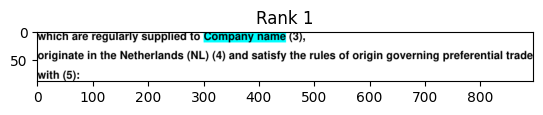

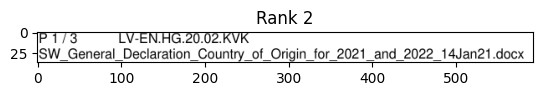

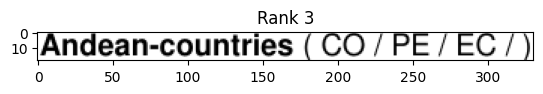

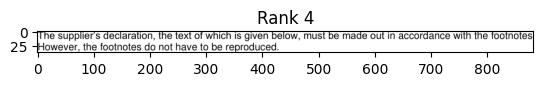

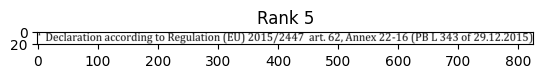

In [16]:
from matplotlib import pyplot as plt


query = "Which company is the creator of this document?"
prmt_embedding = (
    model.get_text_features(
        **tokenizer([query], return_tensors="pt", truncation=True)
    )[0]
    .detach()
    .cpu()
    .numpy()
)

# Calculate the similarity between the prompt and the visual embeddings
similarities = (visual_embeddings @ prmt_embedding.T).squeeze()
print(similarities)

# Get the top 5 most similar extracts
top5 = similarities.argsort()[-5:][::-1]

for i, idx in enumerate(top5):
    plt.figure()
    plt.imshow(extracts[idx])
    plt.title(f"Rank {i+1}")

In [7]:
from dla import run_dla

imgpath = r"D:\workspace\doc-understanding\data\images\sd_2_00.png"
extracts = run_dla(imgpath)

from ocr import run_ocr

ocrresults = []
for e in extracts:
    ocrresults.append(run_ocr(e))


image 1/1 D:\workspace\doc-understanding\data\images\sd_2_00.png: 640x480 2 Pictures, 15 Texts, 177.2ms
Speed: 2.1ms preprocess, 177.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 480)


In [8]:
query = ["Which company is the creator of this document?"]
texts = [" ".join(ocrresult) for ocrresult in ocrresults]


from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F

from torch import Tensor

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]



# Initialize the model
tokenizer = AutoTokenizer.from_pretrained("intfloat/multilingual-e5-large", cache_dir="cache/")
model = AutoModel.from_pretrained("intfloat/multilingual-e5-large", cache_dir="cache/")

# Tokenize the input texts
query_dict = tokenizer(
    query, max_length=512, padding=True, truncation=True, return_tensors="pt"
)

text_dict = tokenizer(
    texts, max_length=512, padding=True, truncation=True, return_tensors="pt"
)

query_embed = model(**query_dict)
query_embed = average_pool(query_embed.last_hidden_state, query_dict["attention_mask"])
query_embed = F.normalize(query_embed, p=2, dim=1)
text_embed = model(**text_dict)
text_embed = average_pool(text_embed.last_hidden_state, text_dict["attention_mask"])
text_embed = F.normalize(text_embed, p=2, dim=1)


scores = (query_embed @ text_embed.T).squeeze()
print(scores.tolist())


[0.7627174854278564, 0.7897469997406006, 0.7907068729400635, 0.7885030508041382, 0.7813950181007385, 0.7846439480781555, 0.7967460751533508, 0.7912884950637817, 0.7761808037757874, 0.7601126432418823, 0.8077341914176941, 0.7723582983016968, 0.7629275918006897, 0.7978872060775757, 0.7886542677879333, 0.7925629019737244, 0.7785114645957947]


In [ ]:
# Show most similar extracts
import matplotlib.pyplot as plt

top5 = scores.argsort(descending=True)
for i, idx in enumerate(top5):
    plt.figure()
    plt.imshow(extracts[idx])
    plt.title(f"Rank {i+1} with score {scores[idx]:.4f}")

In [95]:
import open_clip
CACHE_DIR = "cache/"
model, preprocess = open_clip.create_model_from_pretrained('hf-hub:laion/CLIP-ViT-g-14-laion2B-s12B-b42K', cache_dir=CACHE_DIR)
tokenizer = open_clip.get_tokenizer('hf-hub:laion/CLIP-ViT-g-14-laion2B-s12B-b42K', cache_dir=CACHE_DIR)

In [96]:
import torch
from PIL import Image
from pathlib import Path

from dla import run_dla
from ocr import run_ocr

In [97]:
imgpath = r"D:\workspace\doc-understanding\data\images\ror_1_00.png"
imgname = Path(imgpath).stem
extracts, labels = run_dla(imgpath)
print(labels)


image 1/1 D:\workspace\doc-understanding\data\images\ror_1_00.png: 640x480 2 Page-footers, 2 Pictures, 1 Section-header, 1 Table, 2 Texts, 2 Titles, 119.9ms
Speed: 173.8ms preprocess, 119.9ms inference, 96.3ms postprocess per image at shape (1, 3, 640, 480)
[4.0, 6.0, 4.0, 9.0, 10.0, 8.0, 9.0, 7.0, 6.0, 10.0]


In [98]:
# labels = [9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 6.0, 9.0, 9.0, 9.0, 9.0, 9.0, 6.0, 9.0, 9.0]
ID2LABEL = {
    0: "Caption",
    1: "Footnote",
    2: "Formula",
    3: "List-item",
    4: "Page-footer",
    5: "Page-header",
    6: "Picture",
    7: "Section-header",
    8: "Table",
    9: "Text",
    10: "Title",
}
if not str(labels[0]).isalpha():
    labels = [ID2LABEL[int(label)] for label in labels]
labels

['Page-footer',
 'Picture',
 'Page-footer',
 'Text',
 'Title',
 'Table',
 'Text',
 'Section-header',
 'Picture',
 'Title']

In [99]:
import PIL


texts = []
imgs = []
for e,l in zip(extracts,labels):
    if l.lower() not in ["picture","formula","table"]:
        texts.append(run_ocr([e]).render())
    else:
        to_pil = PIL.Image.fromarray(e)
        image = preprocess(to_pil)
        imgs.append(image)

texts = tokenizer(texts)

In [108]:
query = """{
    "page_number": int,
    }
    """
q = tokenizer(query)

In [109]:
texts[0].shape, imgs[0].shape, q.shape

(torch.Size([77]), torch.Size([3, 224, 224]), torch.Size([1, 77]))

In [110]:
with torch.no_grad(), torch.cuda.amp.autocast():
    q_features = model.encode_text(q)
    t_features = model.encode_text(texts)
    # stack images
    imgs_T = torch.stack(imgs)
    i_features = model.encode_image(imgs_T)

    q_features /= q_features.norm(dim=-1, keepdim=True)
    t_features /= t_features.norm(dim=-1, keepdim=True)
    i_features /= i_features.norm(dim=-1, keepdim=True)

    # concatenate text and image features
    all_features = torch.cat([i_features, t_features], dim=0)
    
    # calculate similarity scores
    sim = (100.0 * q_features @ all_features.T).softmax(dim=-1)
print(sim)

C:\Users\ihett\AppData\Local\Temp\ipykernel_10900\414809023.py:1: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


tensor([[4.1124e-25, 2.5790e-24, 2.5790e-24, 1.7348e-11, 1.0000e+00, 9.2281e-07, 1.7348e-11, 9.3113e-10, 2.4923e-08, 1.2846e-13]])


tensor([4, 5, 8, 7, 3, 6, 9, 1, 2, 0])


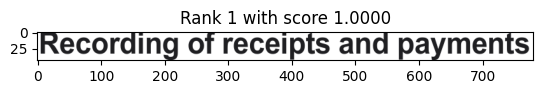

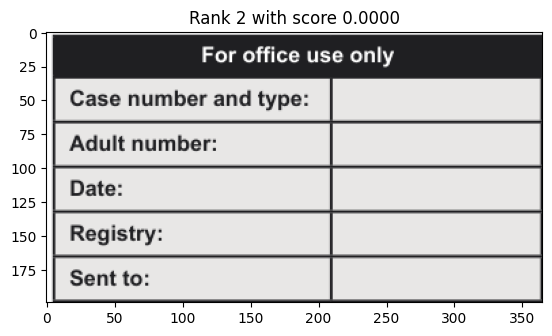

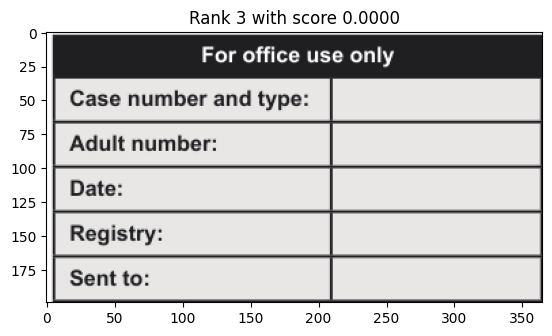

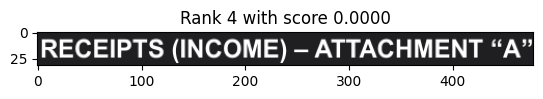

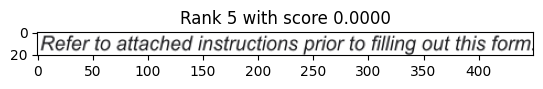

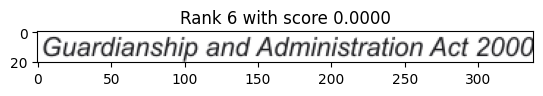

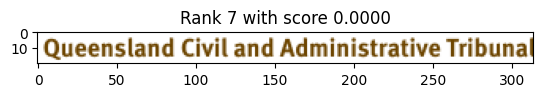

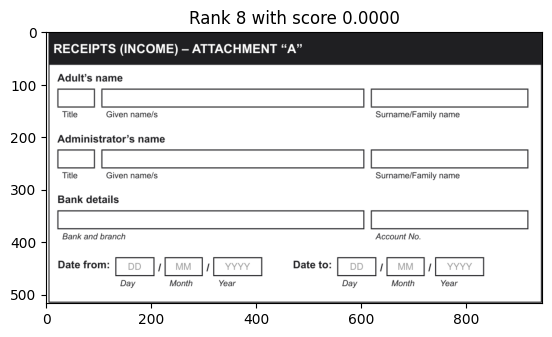

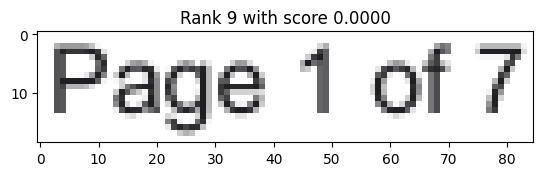

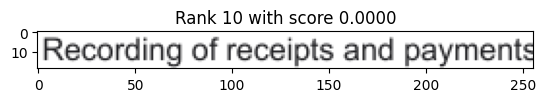

In [111]:
# Show most similar extracts
import matplotlib.pyplot as plt

top5 = sim.argsort(descending=True)[0]
print(top5)
for i, idx in enumerate(top5):
    idx = idx.item()
    plt.figure()
    plt.imshow(extracts[idx])
    plt.title(f"Rank {i+1} with score {sim[0][idx]:.4f}")
    plt.show()
